# `PREDICTING STUDENT TEST SCORES - KAGGLE PLAYGROUND S6E1`

> Goal: Predict students' exam_score using RMSE metric


> ### TABLE OF CONTENTS
> 1. Setup & Imports
> 2. Load Data
> 3. Exploratory Data Analysis (EDA)
> 4. Data Preprocessing
> 5. Feature Engineering
> 6. Model Building
> 7. Model Evaluation & Comparison
> 8. Hyperparameter Tuning
> 9. Ensemble Methods
> 10. Final Predictions & Submission

# `STEP 1: SETUP & IMPORTS`

Why these libraries? 
- pandas/numpy:  Data manipulation
- matplotlib/seaborn:  Visualization
- sklearn: Machine learning algorithms
- xgboost/lightgbm/catboost:  Gradient boosting (competition winners!)
- optuna:  Smart hyperparameter tuning


In [1]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Advanced Gradient Boosting (The Secret Weapons!)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
from optuna.samplers import TPESampler

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Runtime controls to keep runs within time limits (e.g., avoid 12h cancellations)
FAST_MODE = True  # Set to False for the full, slower pipeline
N_FOLDS = 3 if FAST_MODE else 5  # Cross-val folds
OPTUNA_TRIALS = 10 if FAST_MODE else 50  # Number of Optuna trials
OPTUNA_CV = 2 if FAST_MODE else 3  # CV folds used inside Optuna objectives
FAST_ESTIMATORS = 300 if FAST_MODE else 600  # Trees/iterations for quick models

# `STEP 2: LOAD DATA`

GRANDMASTER TIP #1: Always explore your data paths first!
- train.csv: Our learning data (features + target)
- test.csv: Data we need to predict
- sample_submission.csv: Format for our answers

In [3]:
# Load the datasets
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')

# Quick peek at data shapes
print("DATA SHAPES:")
print(f"   Training set:{train.shape[0]:,} rows × {train.shape[1]} columns")
print(f"   Test set:{test.shape[0]:,} rows × {test.shape[1]} columns")
print(f"   Submission:{sample_submission.shape[0]:,} rows × {sample_submission.shape[1]} columns")

DATA SHAPES:
   Training set:630,000 rows × 13 columns
   Test set:270,000 rows × 12 columns
   Submission:270,000 rows × 2 columns


#  `STEP 3: EXPLORATORY DATA ANALYSIS (EDA)`
GRANDMASTER TIP #2: EDA is where competitions are won or lost! 

Spend 30-40% of your time here understanding the data deeply. 

> ## 3.1 First Look at the Data

In [4]:
print("\n TRAINING DATA - FIRST 5 ROWS:")
print(train.head())

print("\n TRAINING DATA - INFO:")
print(train.info())

print("\n TRAINING DATA - STATISTICS:")
print(train.describe())


 TRAINING DATA - FIRST 5 ROWS:
   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   

   exam_score  
0       

> ## 3.2 Check Column Names and Types

In [5]:
print("\n COLUMN NAMES AND DATA TYPES:")
for col in train.columns:
    print(f"   {col}: {train[col].dtype}")

# Identify column types
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

# Remove 'id' and 'exam_score' from numerical columns for analysis
numerical_features = [col for col in numerical_cols if col not in ['id', 'exam_score']]

print(f"\n Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f" Categorical Features ({len(categorical_cols)}): {categorical_cols}")


 COLUMN NAMES AND DATA TYPES:
   id: int64
   age: int64
   gender: object
   course: object
   study_hours: float64
   class_attendance: float64
   internet_access: object
   sleep_hours: float64
   sleep_quality: object
   study_method: object
   facility_rating: object
   exam_difficulty: object
   exam_score: float64

 Numerical Features (4): ['age', 'study_hours', 'class_attendance', 'sleep_hours']
 Categorical Features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


> ## 3.3 Target Variable Analysis


TARGET VARIABLE ANALYSIS:  exam_score
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


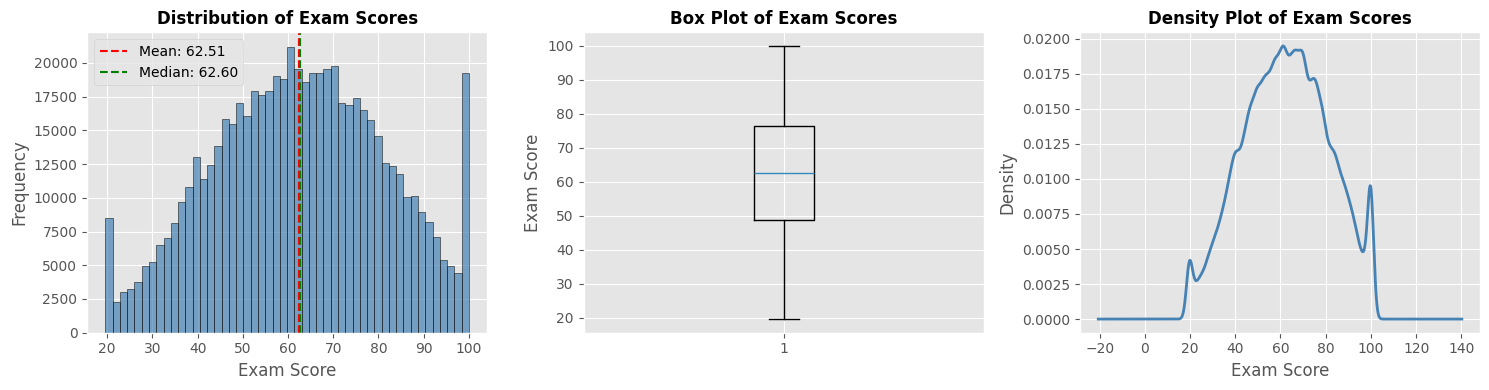


 INSIGHT: Check if the distribution is normal or skewed.
   - If skewed, consider log transformation for better model performance.


In [6]:
print("\nTARGET VARIABLE ANALYSIS:  exam_score")
print(train['exam_score'].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(train['exam_score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Exam Scores', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train['exam_score'].mean(), color='red', linestyle='--', label=f"Mean: {train['exam_score'].mean():.2f}")
axes[0].axvline(train['exam_score'].median(), color='green', linestyle='--', label=f"Median: {train['exam_score'].median():.2f}")
axes[0].legend()

# Box plot
axes[1].boxplot(train['exam_score'], vert=True)
axes[1].set_title('Box Plot of Exam Scores', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Exam Score')

# KDE plot
train['exam_score'].plot(kind='kde', ax=axes[2], color='steelblue', linewidth=2)
axes[2].set_title('Density Plot of Exam Scores', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Exam Score')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n INSIGHT: Check if the distribution is normal or skewed.")
print("   - If skewed, consider log transformation for better model performance.")

> ## 3.4 Missing Values Analysis
GRANDMASTER TIP #3: Missing values can make or break your model! <br>
Always handle them strategically. 

No missing values found!  Great news!


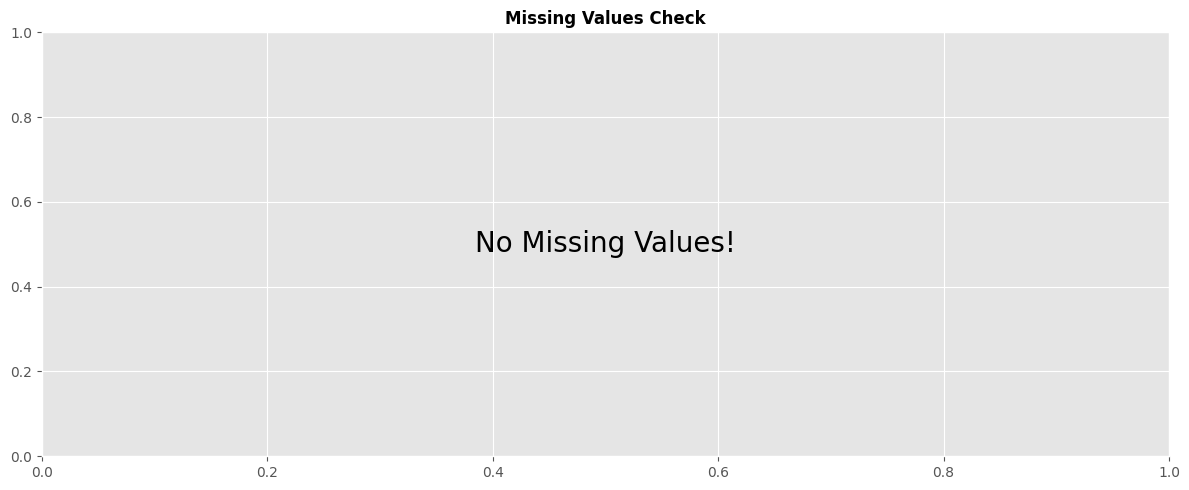

In [7]:
# Check missing values in train
train_missing = train.isnull().sum()
train_missing_pct = (train_missing / len(train)) * 100

# Check missing values in test
test_missing = test.isnull().sum()
test_missing_pct = (test_missing / len(test)) * 100

# Create summary DataFrame
missing_df = pd.DataFrame({
    'Train_Missing': train_missing,
    'Train_Missing_%': train_missing_pct,
    'Test_Missing':  test_missing,
    'Test_Missing_%': test_missing_pct
})

# Show only columns with missing values
missing_with_values = missing_df[(missing_df['Train_Missing'] > 0) | (missing_df['Test_Missing'] > 0)]

if len(missing_with_values) > 0:
    print(missing_with_values)
else:
    print("No missing values found!  Great news!")

# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 5))
missing_pct = train.isnull().sum() / len(train) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

if len(missing_pct) > 0:
    missing_pct.plot(kind='bar', color='coral', ax=ax)
    ax.set_title('Percentage of Missing Values by Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage Missing (%)')
    ax.set_xlabel('Features')
    plt.xticks(rotation=45, ha='right')
else:
    ax.text(0.5, 0.5, 'No Missing Values!', fontsize=20, ha='center', va='center')
    ax.set_title('Missing Values Check', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

> ## 3.5 Numerical Features Distribution

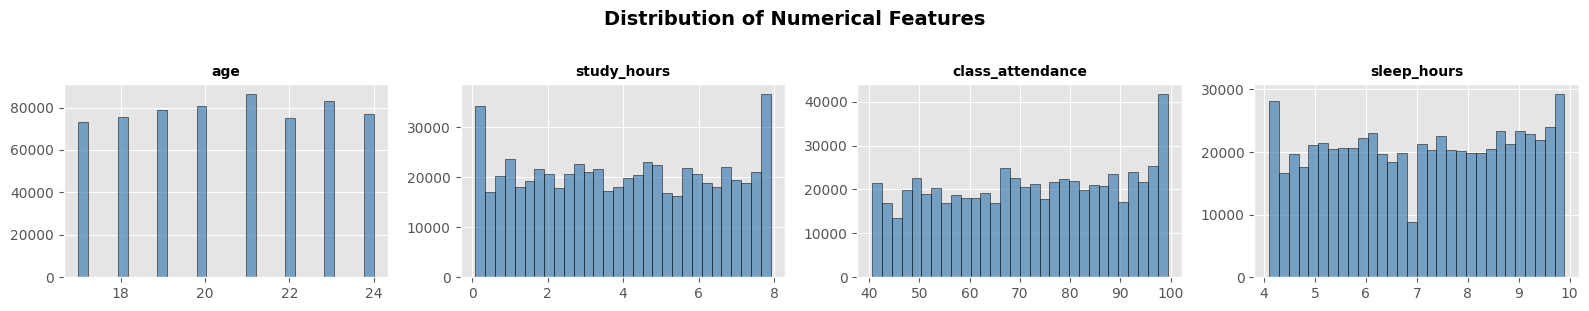

In [8]:
# Calculate grid size
n_features = len(numerical_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(train[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')
    
# Hide empty subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('numerical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

> ## 3.6 Categorical Features Analysis


    gender:
      Unique values: 3
      Values: ['female' 'other' 'male']...

    course:
      Unique values: 7
      Values: ['b.sc' 'diploma' 'bca' 'b.com' 'ba' 'bba' 'b.tech']...

    internet_access:
      Unique values: 2
      Values: ['no' 'yes']...

    sleep_quality:
      Unique values: 3
      Values: ['average' 'poor' 'good']...

    study_method:
      Unique values: 5
      Values: ['online videos' 'self-study' 'coaching' 'group study' 'mixed']...

    facility_rating:
      Unique values: 3
      Values: ['low' 'medium' 'high']...

    exam_difficulty:
      Unique values: 3
      Values: ['easy' 'moderate' 'hard']...


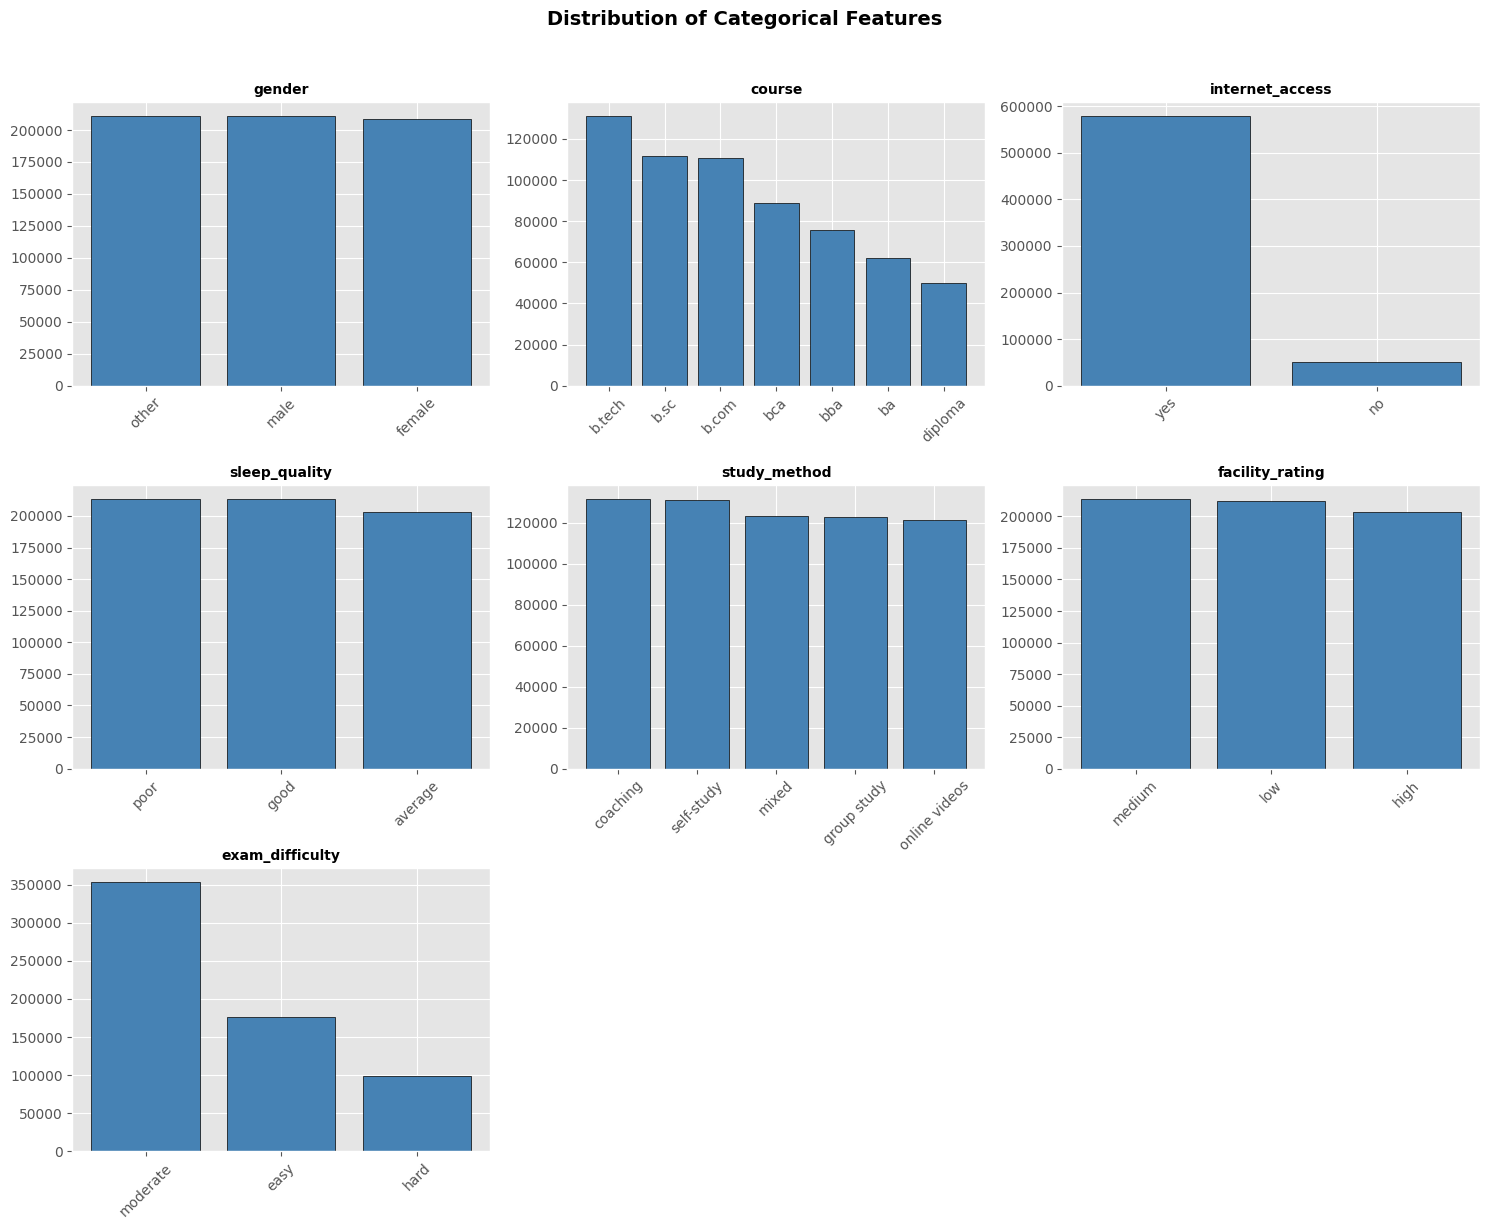

In [9]:
if len(categorical_cols) > 0:
    for col in categorical_cols:
        print(f"\n    {col}:")
        print(f"      Unique values: {train[col].nunique()}")
        print(f"      Values: {train[col].unique()[:10]}...")  # Show first 10
        
    # Visualize categorical distributions
    n_cats = len(categorical_cols)
    n_cols_plot = min(3, n_cats)
    n_rows_plot = (n_cats + n_cols_plot - 1) // n_cols_plot
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 4))
    if n_cats == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols):
        value_counts = train[col].value_counts()
        axes[idx].bar(value_counts.index.astype(str), value_counts.values, color='steelblue', edgecolor='black')
        axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for idx in range(len(categorical_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Distribution of Categorical Features', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('categorical_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("   No categorical features found!")

> ## 3.7 Correlation Analysis

GRANDMASTER TIP #4: Correlation helps identify: 
- Features strongly related to target (good!)
- Multicollinearity between features (watch out!)


Features Most Correlated with Exam Score:
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64


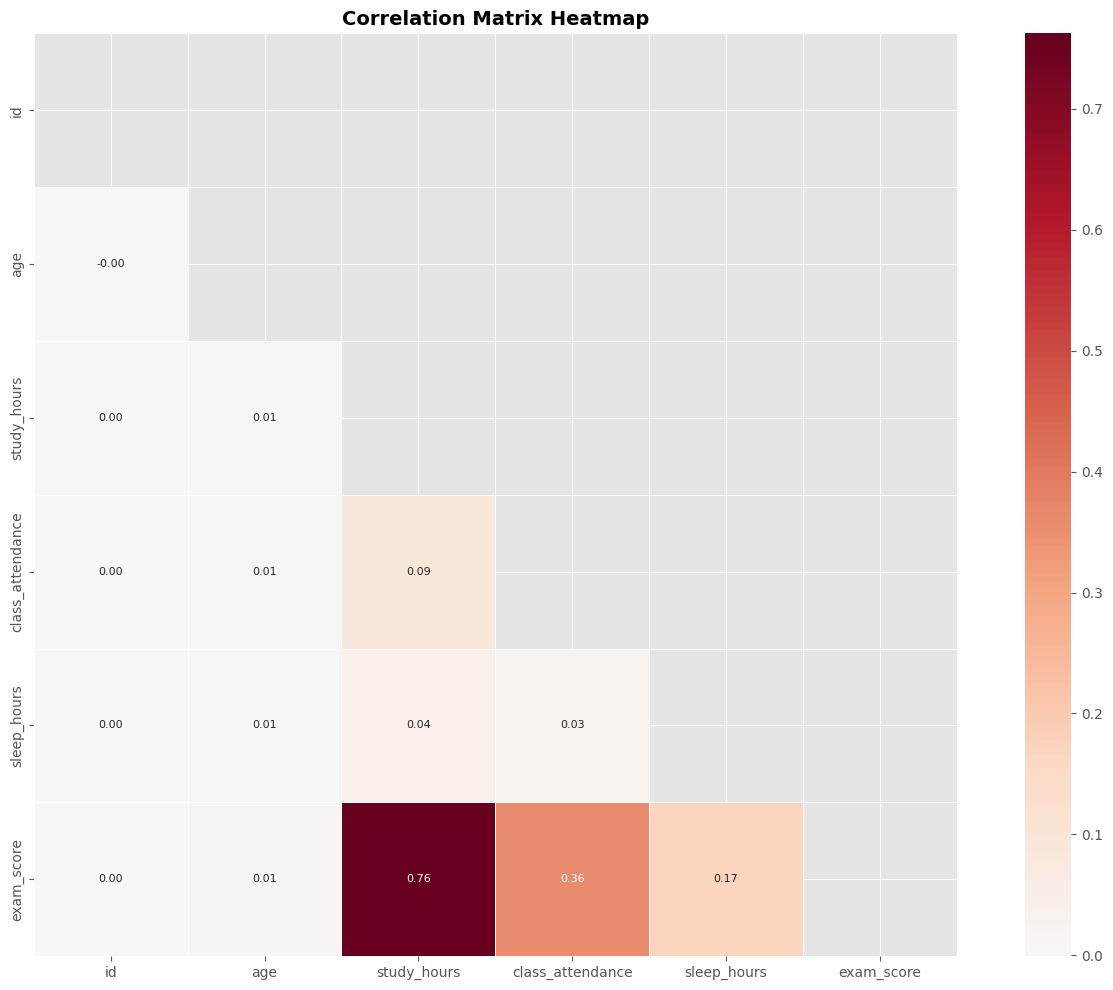

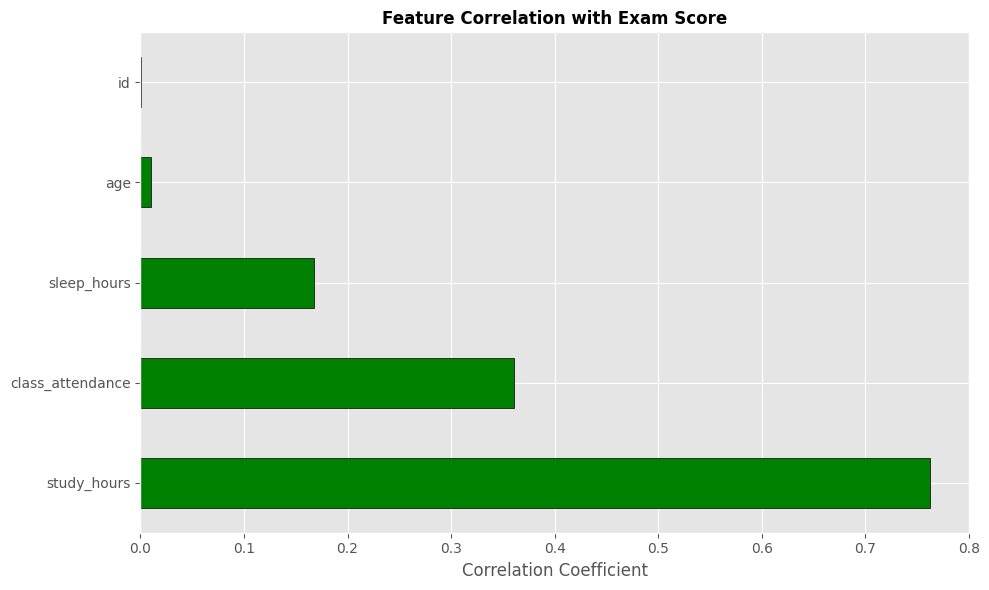

In [10]:
# Calculate correlation matrix
correlation_matrix = train[numerical_cols].corr()

# Correlation with target
target_correlation = correlation_matrix['exam_score'].drop('exam_score').sort_values(ascending=False)
print("\nFeatures Most Correlated with Exam Score:")
print(target_correlation)

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            annot_kws={'size': 8})
plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualize target correlations
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in target_correlation.values]
target_correlation.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Feature Correlation with Exam Score', fontsize=12, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

> ## 3.8 Feature vs Target Visualization

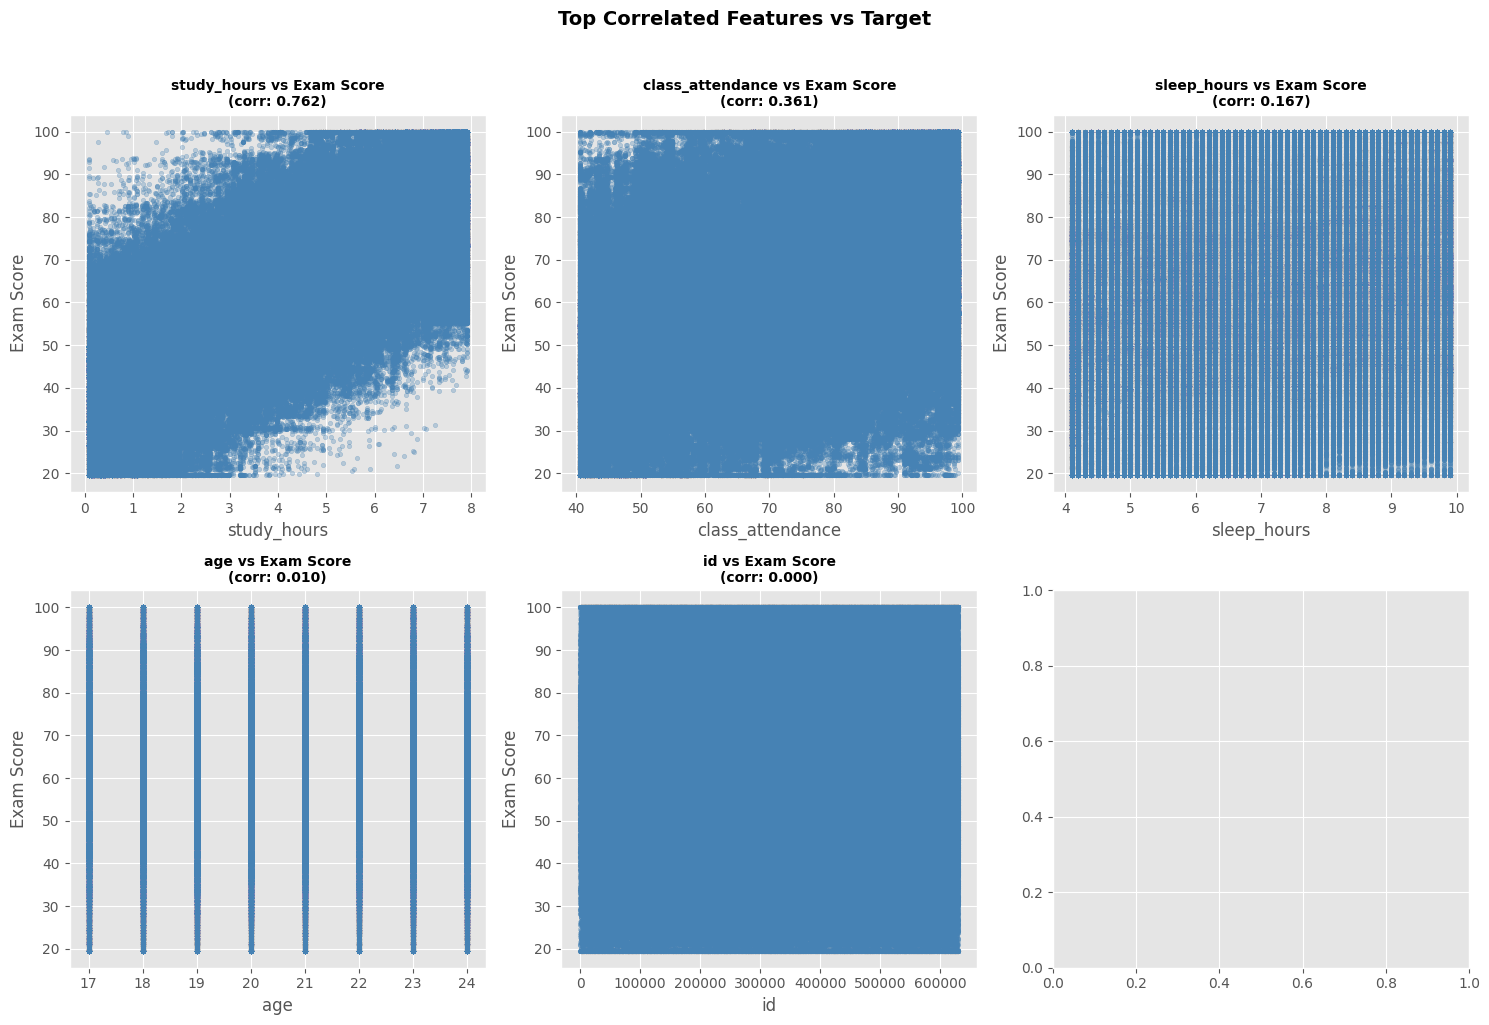

In [11]:
# Scatter plots for top correlated features
top_features = target_correlation.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(top_features):
    axes[idx].scatter(train[col], train['exam_score'], alpha=0.3, s=10, color='steelblue')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Exam Score')
    axes[idx].set_title(f'{col} vs Exam Score\n(corr: {target_correlation[col]:.3f})', fontsize=10, fontweight='bold')

plt.suptitle('Top Correlated Features vs Target', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_vs_target.png', dpi=150, bbox_inches='tight')
plt.show()

> # 3.9 Outlier Detection

GRANDMASTER TIP #5: Outliers can significantly impact model performance. <br> 
Detect them, understand them, and then decide how to handle them. 


   Outliers detected (IQR method):


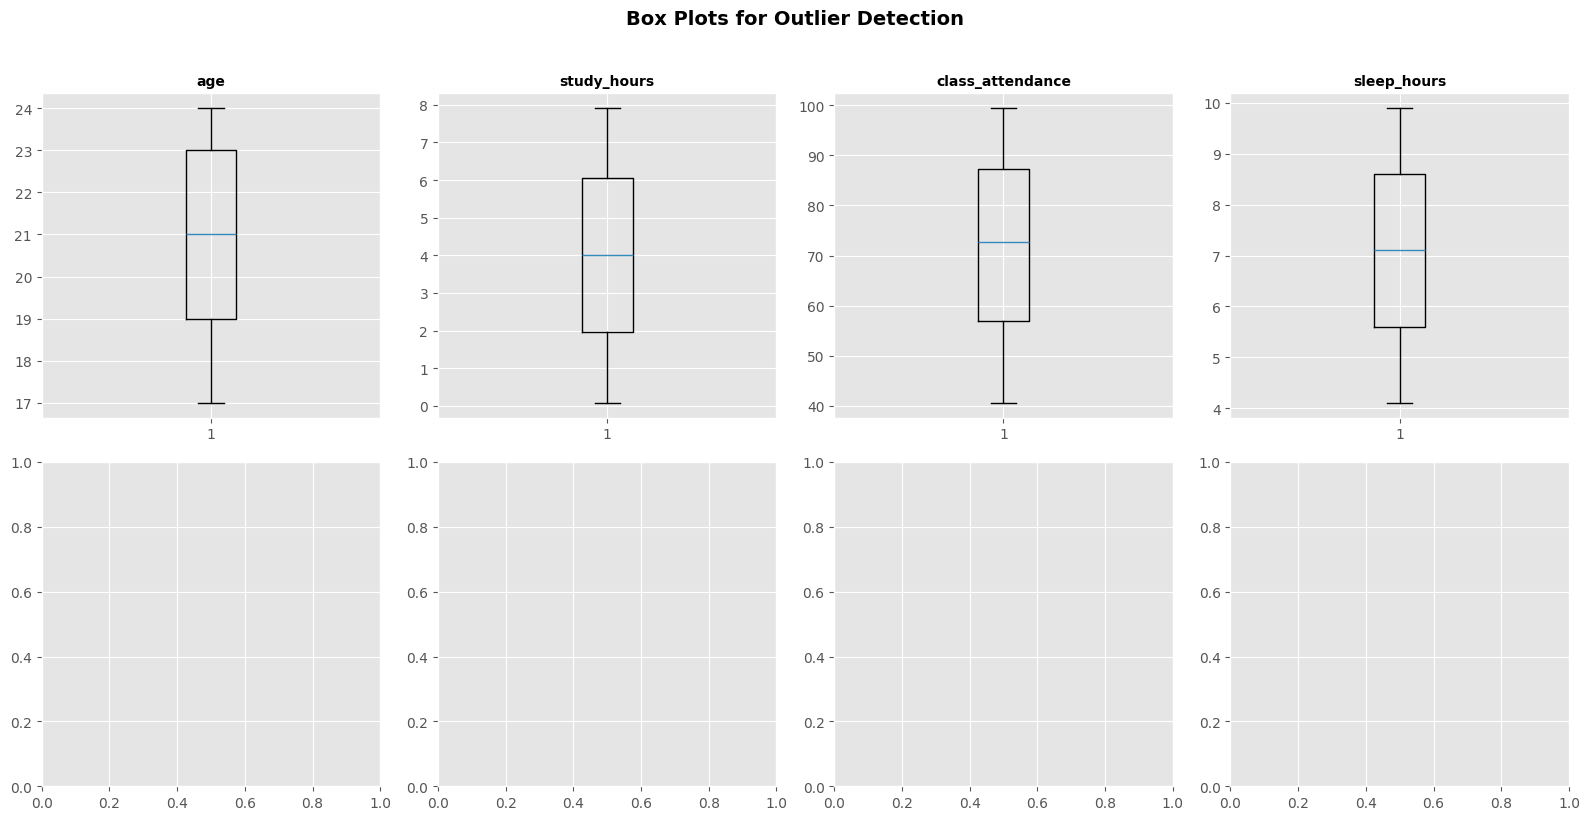

In [12]:
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\n   Outliers detected (IQR method):")
for col in numerical_features[:10]:  # Check first 10 features
    n_outliers, lb, ub = detect_outliers_iqr(train, col)
    pct = (n_outliers / len(train)) * 100
    if pct > 1:  # Only show if more than 1% outliers
        print(f"   {col}: {n_outliers:,} outliers ({pct:.2f}%)")

# Box plots for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(numerical_features[:8]):
    axes[idx].boxplot(train[col].dropna())
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')

plt.suptitle('Box Plots for Outlier Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outliers.png', dpi=150, bbox_inches='tight')
plt.show()

> ## 3.10 Train vs Test Distribution Comparison

GRANDMASTER TIP #6: Always compare train and test distributions! <br>
If they're different, your model might not generalize well.

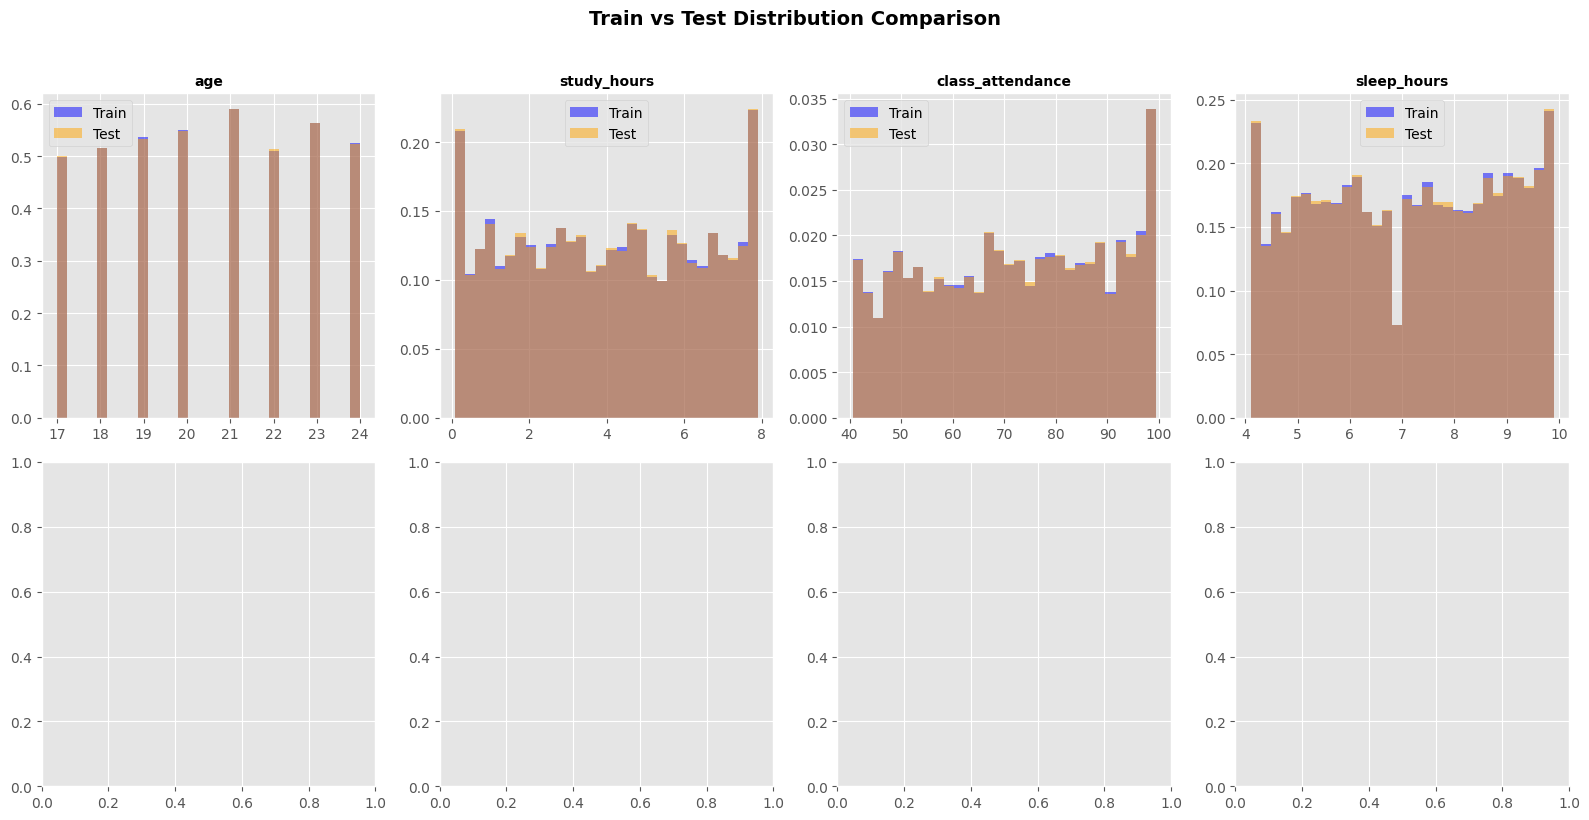


 EDA COMPLETE! Key Insights:
   1. Target distribution shape (normal/skewed)
   2. Missing value patterns
   3. Feature correlations with target
   4. Potential outliers to handle
   5. Train/test distribution alignment


In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(numerical_features[:8]):
    axes[idx].hist(train[col], bins=30, alpha=0.5, label='Train', color='blue', density=True)
    axes[idx].hist(test[col], bins=30, alpha=0.5, label='Test', color='orange', density=True)
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[idx].legend()

plt.suptitle('Train vs Test Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('train_test_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n EDA COMPLETE! Key Insights:")
print("   1. Target distribution shape (normal/skewed)")
print("   2. Missing value patterns")
print("   3. Feature correlations with target")
print("   4. Potential outliers to handle")
print("   5. Train/test distribution alignment")

# STEP 4: DATA PREPROCESSING

GRANDMASTER TIP #7: Clean preprocessing = Clean predictions! <br>
Handle missing values, encode categories, scale features. 

> ## 4.1 Separate Features and Target

In [14]:
# Store IDs for later
train_ids = train['id']
test_ids = test['id']

# Separate features and target
X = train.drop(['id', 'exam_score'], axis=1)
y = train['exam_score']
X_test = test.drop(['id'], axis=1)

print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   X_test shape: {X_test.shape}")

   X shape: (630000, 11)
   y shape: (630000,)
   X_test shape: (270000, 11)


> ## 4.2 Handle Missing Values

In [15]:
# Check for missing values
print(f"   Missing in X: {X.isnull().sum().sum()}")
print(f"   Missing in X_test: {X_test.isnull().sum().sum()}")

# Strategy: 
# - Numerical:  Fill with median (robust to outliers)
# - Categorical:  Fill with mode (most frequent)

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        # Fill with median
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        X_test[col].fillna(median_val, inplace=True)
    else:
        # Fill with mode
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        X_test[col].fillna(mode_val, inplace=True)

print(f"   After filling - Missing in X: {X.isnull().sum().sum()}")
print(f"   After filling - Missing in X_test: {X_test.isnull().sum().sum()}")

   Missing in X: 0
   Missing in X_test: 0
   After filling - Missing in X: 0
   After filling - Missing in X_test: 0


> ## 4.3 Encode Categorical Variables

In [16]:
# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"   Categorical columns:  {cat_cols}")

if len(cat_cols) > 0:
    # Label Encoding for tree-based models
    label_encoders = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        # Fit on combined train + test to handle unseen categories
        combined = pd.concat([X[col], X_test[col]], axis=0)
        le.fit(combined.astype(str))
        
        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
        
    print(f"   Encoded {len(cat_cols)} categorical columns")
else:
    print("   No categorical columns to encode")

   Categorical columns:  ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
   Encoded 7 categorical columns


> ## 4.4 Feature Scaling

GRANDMASTER TIP #8: Scaling helps certain algorithms (Linear, SVM, KNN). <br>
Tree-based models don't need it, but it doesn't hurt! 

In [17]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"  Features scaled using StandardScaler")

# Keep both scaled and unscaled versions
# - Unscaled: For tree-based models (XGBoost, LightGBM, CatBoost)
# - Scaled:  For linear models, SVM, KNN

  Features scaled using StandardScaler


# `STEP 5: FEATURE ENGINEERING`
GRANDMASTER TIP #9: Feature engineering is where magic happens! <br>
Create new features that capture hidden patterns in the data.

> ## 5.1 Basic Feature Engineering Functions

In [18]:
def create_features(df):
    """
    Create new features from existing ones. 
    FAST_MODE trims the feature set to keep runtime reasonable.
    """
    df = df.copy()

    # Get numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if FAST_MODE:
        num_cols = num_cols[:20]  # limit columns considered for fast runs

    # 1. Statistical Features (aggregations across rows)
    if len(num_cols) >= 3:
        df['mean_features'] = df[num_cols].mean(axis=1)
        df['std_features'] = df[num_cols].std(axis=1)
        df['min_features'] = df[num_cols].min(axis=1)
        df['max_features'] = df[num_cols].max(axis=1)
        df['range_features'] = df['max_features'] - df['min_features']
        df['median_features'] = df[num_cols].median(axis=1)

    # 2. Polynomial Features for a small subset of columns
    poly_cols = num_cols[:3] if FAST_MODE else num_cols[:5]
    for col in poly_cols:
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_sqrt'] = np.sqrt(np.abs(df[col]))
        df[f'{col}_log'] = np.log1p(np.abs(df[col]))

    # 3. Interaction Features (trimmed in FAST_MODE)
    interaction_cols = num_cols[:2] if FAST_MODE else num_cols[:3]
    for i, col1 in enumerate(interaction_cols):
        for col2 in interaction_cols[i+1:]:
            df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
            if (df[col2] != 0).all():
                df[f'{col1}_div_{col2}'] = df[col1] / (df[col2] + 1e-8)

    # 4. Binning Features
    bin_count = 6 if FAST_MODE else 10
    for col in interaction_cols:
        df[f'{col}_binned'] = pd.qcut(df[col], q=bin_count, labels=False, duplicates='drop')

    return df

print(" Creating new features...")

X_fe = create_features(X)
X_test_fe = create_features(X_test)

print(f"   Original features: {X.shape[1]}")
print(f"   After feature engineering: {X_fe.shape[1]}")
print(f"   New features created: {X_fe.shape[1] - X.shape[1]}")

X_fe = X_fe.fillna(0)
X_test_fe = X_test_fe.fillna(0)

X_fe = X_fe.replace([np.inf, -np.inf], 0)
X_test_fe = X_test_fe.replace([np.inf, -np.inf], 0)

 Creating new features...
   Original features: 11
   After feature engineering: 29
   New features created: 18


# `STEP 6: MODEL BUILDING`

GRANDMASTER TIP #10: Try multiple models, then ensemble the best ones! <br>
Start simple, then go complex. 

> ## 6.1 Train-Validation Split

In [19]:
print("\n Creating train-validation split...")

X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"   Training set:  {X_train.shape}")
print(f"   Validation set:  {X_val.shape}")


 Creating train-validation split...
   Training set:  (504000, 29)
   Validation set:  (126000, 29)


> ## 6.2 Define Models to Try

Model Selection Strategy:
1. Baseline:  Linear Regression
2. Regularized: Ridge, Lasso, ElasticNet
3. Tree-based: Random Forest, Extra Trees
4. Gradient Boosting: XGBoost, LightGBM, CatBoost (Competition Winners!)
5. Others: KNN, SVR

In [20]:
print("\n Defining models...")

if FAST_MODE:
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest (fast)': RandomForestRegressor(n_estimators=FAST_ESTIMATORS, max_depth=12,
                                                     random_state=RANDOM_STATE, n_jobs=-1),
        'Extra Trees (fast)': ExtraTreesRegressor(n_estimators=FAST_ESTIMATORS, max_depth=12,
                                                 random_state=RANDOM_STATE, n_jobs=-1),
        'LightGBM (fast)': LGBMRegressor(n_estimators=FAST_ESTIMATORS, max_depth=8, learning_rate=0.05,
                                         subsample=0.8, colsample_bytree=0.8,
                                         random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
        'XGBoost (fast)': XGBRegressor(n_estimators=FAST_ESTIMATORS, max_depth=8, learning_rate=0.05,
                                       subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                                       random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
    }
else:
    models = {
        # Linear Models
        'Linear Regression': LinearRegression(),
        'Ridge':  Ridge(alpha=1.0, random_state=RANDOM_STATE),
        'Lasso':  Lasso(alpha=0.1, random_state=RANDOM_STATE),
        'ElasticNet':  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
        
        # Tree-based Models
        'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10,
                                               random_state=RANDOM_STATE, n_jobs=-1),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=10,
                                           random_state=RANDOM_STATE, n_jobs=-1),
        
        # Gradient Boosting Models (THE WINNERS!)
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
        'LightGBM': LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                  random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
        'CatBoost':  CatBoostRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                      random_state=RANDOM_STATE, verbose=0),
        
        # Other Models
        'KNN': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    }
print(f"   Total models to evaluate: {len(models)}")


 Defining models...
   Total models to evaluate: 5


> ## 6.3 Train and Evaluate All Models

   Training Linear Regression... RMSE: 9.9404
   Training Random Forest (fast)... RMSE: 8.9704
   Training Extra Trees (fast)... RMSE: 8.9709
   Training LightGBM (fast)... RMSE: 8.7903
   Training XGBoost (fast)... RMSE: 8.7688

 MODEL COMPARISON (sorted by RMSE - lower is better):
               Model     RMSE      MAE       R2
      XGBoost (fast) 8.768773 6.991925 0.783799
     LightGBM (fast) 8.790293 7.015375 0.782736
Random Forest (fast) 8.970395 7.162945 0.773742
  Extra Trees (fast) 8.970905 7.179371 0.773716
   Linear Regression 9.940374 7.979223 0.722166


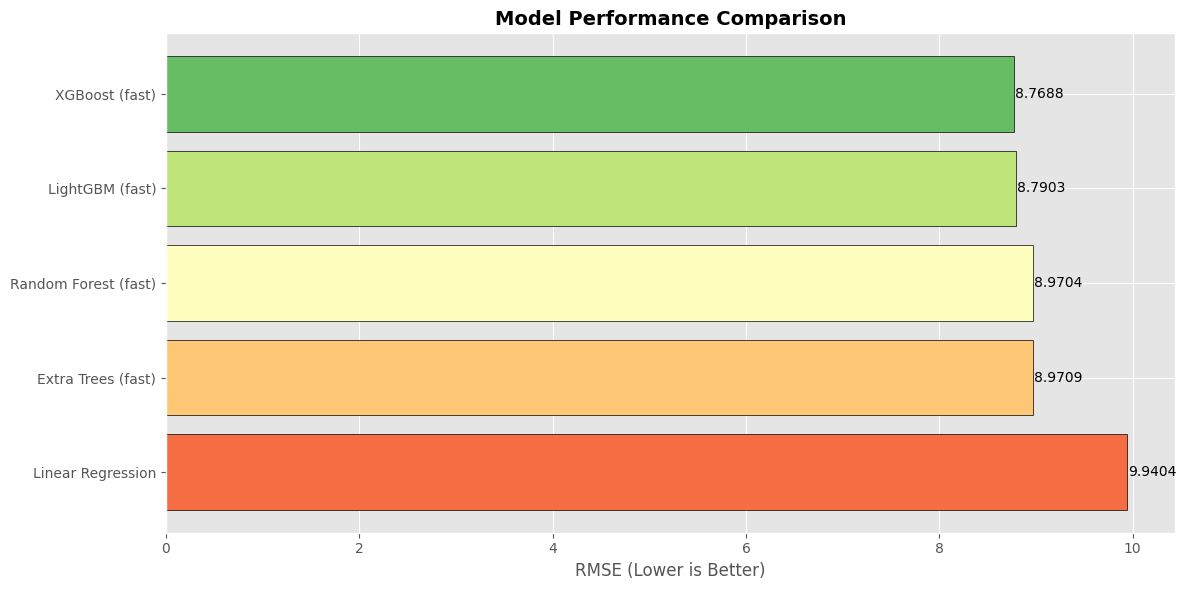

In [21]:
def evaluate_model(model, X_train, X_val, y_train, y_val):
    """Train model and return metrics"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    return rmse, mae, r2, y_pred

results = []

for name, model in models.items():
    print(f"   Training {name}...", end=" ")
    try:
        rmse, mae, r2, _ = evaluate_model(model, X_train, X_val, y_train, y_val)
        results.append({
            'Model': name,
            'RMSE':  rmse,
            'MAE': mae,
            'R2': r2
        })
        print(f"RMSE: {rmse:.4f}")
    except Exception as e: 
        print(f"Error:  {e}")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('RMSE', ascending=True)
print("\n MODEL COMPARISON (sorted by RMSE - lower is better):")

print(results_df.to_string(index=False))

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(results_df)))
bars = ax.barh(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')
ax.set_xlabel('RMSE (Lower is Better)', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, rmse in zip(bars, results_df['RMSE']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{rmse:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# `STEP 7: CROSS-VALIDATION`

GRANDMASTER TIP #11: Always use cross-validation! <br>
It gives you a more reliable estimate of model performance.

Cross-validating top models: ['XGBoost (fast)', 'LightGBM (fast)']

   Cross-validating XGBoost (fast)...
      Mean RMSE: 8.7886 (+/- 0.0119)
      Fold scores: [8.77496151 8.78676242 8.80395578]

   Cross-validating LightGBM (fast)...
      Mean RMSE: 8.8033 (+/- 0.0092)
      Fold scores: [8.79272645 8.8020293  8.81509615]

 CROSS-VALIDATION RESULTS:
          Model  CV_Mean_RMSE  CV_Std_RMSE  CV_Min_RMSE  CV_Max_RMSE
 XGBoost (fast)      8.788560     0.011905     8.774962     8.803956
LightGBM (fast)      8.803284     0.009175     8.792726     8.815096


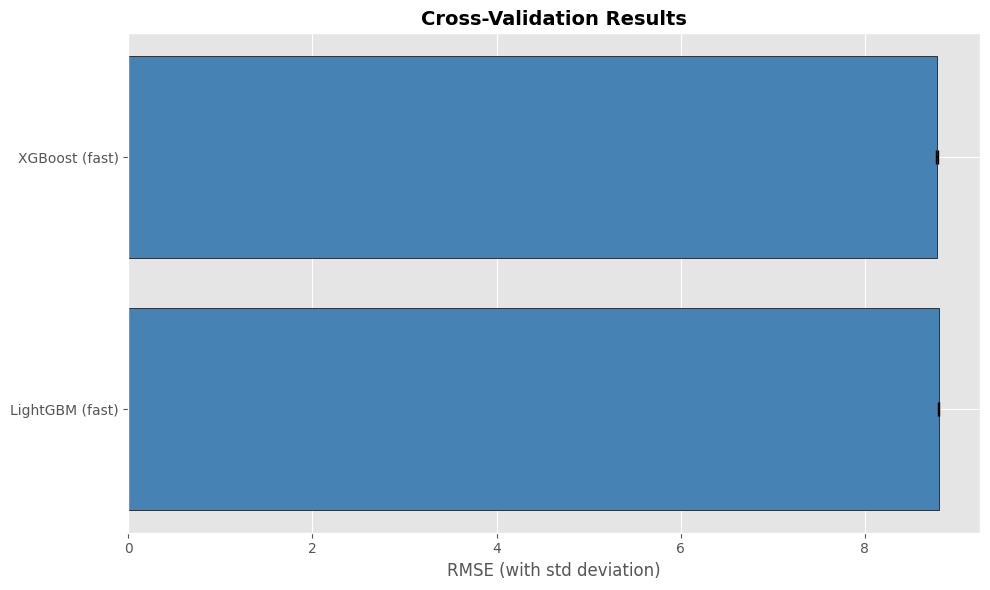

In [22]:
# Select top models for cross-validation
top_k = 2 if FAST_MODE else 3
top_models = results_df.head(top_k)['Model'].tolist()
print(f"Cross-validating top models: {top_models}")

# Define K-Fold
n_folds = N_FOLDS
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

cv_results = []

for name in top_models: 
    model = models[name]
    print(f"\n   Cross-validating {name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_fe, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_rmse = -cv_scores  # Convert to positive RMSE
    
    cv_results.append({
        'Model': name,
        'CV_Mean_RMSE':  cv_rmse.mean(),
        'CV_Std_RMSE': cv_rmse.std(),
        'CV_Min_RMSE': cv_rmse.min(),
        'CV_Max_RMSE':  cv_rmse.max()
    })
    
    print(f"      Mean RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
    print(f"      Fold scores: {cv_rmse}")

cv_results_df = pd.DataFrame(cv_results).sort_values('CV_Mean_RMSE', ascending=True)
print("\n CROSS-VALIDATION RESULTS:")
print(cv_results_df.to_string(index=False))

# Visualize CV results with error bars
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(cv_results_df))
ax.barh(cv_results_df['Model'], cv_results_df['CV_Mean_RMSE'], 
        xerr=cv_results_df['CV_Std_RMSE'], color='steelblue', 
        edgecolor='black', capsize=5)
ax.set_xlabel('RMSE (with std deviation)', fontsize=12)
ax.set_title('Cross-Validation Results', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

# `STEP 8: HYPERPARAMETER TUNING`

GRANDMASTER TIP #12: Hyperparameter tuning can squeeze out extra performance! <br>
Use Optuna for smart, efficient tuning.

> ## 8.1 Tune XGBoost with Optuna

In [23]:
if FAST_MODE:
    print("FAST_MODE enabled: skipping XGBoost Optuna tuning.")
    study_xgb = None
else:
    def objective_xgb(trial):
        """Optuna objective function for XGBoost"""
        params = {
            'n_estimators':  trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample':  trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 5.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
            'random_state':  RANDOM_STATE,
            'n_jobs': -1,
            'verbosity': 0,
            'tree_method': 'hist'
        }
        
        model = XGBRegressor(**params)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_fe, y, cv=OPTUNA_CV, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        return -cv_scores.mean()
    
    study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
    study_xgb.optimize(objective_xgb, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
    
    print(f"\n   Best XGBoost RMSE: {study_xgb.best_value:.4f}")
    print(f"   Best parameters: {study_xgb.best_params}")

FAST_MODE enabled: skipping XGBoost Optuna tuning.


> ## 8.2 Tune LightGBM with Optuna

In [24]:
if FAST_MODE:
    print("FAST_MODE enabled: skipping LightGBM Optuna tuning.")
    study_lgbm = None
else:
    def objective_lgbm(trial):
        """Optuna objective function for LightGBM"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate':  trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample':  trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 80),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 5.0, log=True),
            'reg_lambda':  trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 120),
            'random_state': RANDOM_STATE,
            'n_jobs':  -1,
            'verbose': -1
        }
        
        model = LGBMRegressor(**params)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_fe, y, cv=OPTUNA_CV, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        return -cv_scores.mean()
    
    study_lgbm = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
    study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
    
    print(f"\n   Best LightGBM RMSE: {study_lgbm.best_value:.4f}")
    print(f"   Best parameters:  {study_lgbm.best_params}")

FAST_MODE enabled: skipping LightGBM Optuna tuning.


> ## 8.3 Tune CatBoost with Optuna

In [25]:
if FAST_MODE:
    print("FAST_MODE enabled: skipping CatBoost Optuna tuning.")
    study_catboost = None
else:
    def objective_catboost(trial):
        """Optuna objective function for CatBoost"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 80),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 5.0, log=True),
            'random_state': RANDOM_STATE,
            'verbose': 0
        }
        
        model = CatBoostRegressor(**params)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_fe, y, cv=OPTUNA_CV, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        return -cv_scores.mean()
    
    study_catboost = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
    study_catboost.optimize(objective_catboost, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
    
    print(f"\n   Best CatBoost RMSE: {study_catboost.best_value:.4f}")
    print(f"   Best parameters: {study_catboost.best_params}")

FAST_MODE enabled: skipping CatBoost Optuna tuning.


## 8.4 Create Tuned Models

In [26]:
# Fallback fast defaults for when Optuna is skipped
fast_xgb_params = {
    'n_estimators': FAST_ESTIMATORS,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_weight': 1,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'tree_method': 'hist'
}
fast_lgbm_params = {
    'n_estimators': FAST_ESTIMATORS,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_samples': 20,
    'num_leaves': 80
}
fast_cat_params = {
    'n_estimators': FAST_ESTIMATORS,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bylevel': 0.9,
    'min_child_samples': 20,
    'l2_leaf_reg': 3.0
}

best_xgb_params = study_xgb.best_params if study_xgb is not None else fast_xgb_params
best_lgbm_params = study_lgbm.best_params if study_lgbm is not None else fast_lgbm_params
best_cat_params = study_catboost.best_params if study_catboost is not None else fast_cat_params

best_xgb = XGBRegressor(**best_xgb_params, random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
best_lgbm = LGBMRegressor(**best_lgbm_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
best_catboost = CatBoostRegressor(**best_cat_params, random_state=RANDOM_STATE, verbose=0)

print(" Tuned (or fast-default) models created!")
print("\n HYPERPARAMETER TUNING COMPLETE!")

 Tuned (or fast-default) models created!

 HYPERPARAMETER TUNING COMPLETE!


# `STEP 9: ENSEMBLE METHODS`

GRANDMASTER TIP #13: Ensembling multiple models almost always improves performance! <br>
Techniques: Averaging, Weighted Averaging, Stacking

> ## 9.1 Train Tuned Models

In [27]:
# Train models
best_xgb.fit(X_fe, y)
best_lgbm.fit(X_fe, y)
best_catboost.fit(X_fe, y)

> ## 9.2 Make Individual Predictions

In [28]:
pred_xgb = best_xgb.predict(X_test_fe)
pred_lgbm = best_lgbm.predict(X_test_fe)
pred_catboost = best_catboost.predict(X_test_fe)

print(f"   XGBoost predictions: min={pred_xgb.min():.2f}, max={pred_xgb.max():.2f}, mean={pred_xgb.mean():.2f}")
print(f"   LightGBM predictions: min={pred_lgbm.min():.2f}, max={pred_lgbm.max():.2f}, mean={pred_lgbm.mean():.2f}")
print(f"   CatBoost predictions: min={pred_catboost.min():.2f}, max={pred_catboost.max():.2f}, mean={pred_catboost.mean():.2f}")

   XGBoost predictions: min=15.54, max=103.59, mean=62.52
   LightGBM predictions: min=16.25, max=103.41, mean=62.52
   CatBoost predictions: min=15.93, max=103.56, mean=62.52


> ## 9.3 Simple Averaging Ensemble

In [29]:
# Simple average
ensemble_avg = (pred_xgb + pred_lgbm + pred_catboost) / 3

# Weighted average (based on CV performance)
# Adjust weights based on your CV results! 
xgb_weight = 0.35
lgbm_weight = 0.35
catboost_weight = 0.30

ensemble_weighted = (xgb_weight * pred_xgb + 
                     lgbm_weight * pred_lgbm + 
                     catboost_weight * pred_catboost)

print(f"   Simple Average: min={ensemble_avg.min():.2f}, max={ensemble_avg.max():.2f}, mean={ensemble_avg.mean():.2f}")
print(f"   Weighted Average:  min={ensemble_weighted.min():.2f}, max={ensemble_weighted.max():.2f}, mean={ensemble_weighted.mean():.2f}")

   Simple Average: min=15.91, max=103.52, mean=62.52
   Weighted Average:  min=15.91, max=103.52, mean=62.52


> ## 9.4 Visualize Prediction Distributions

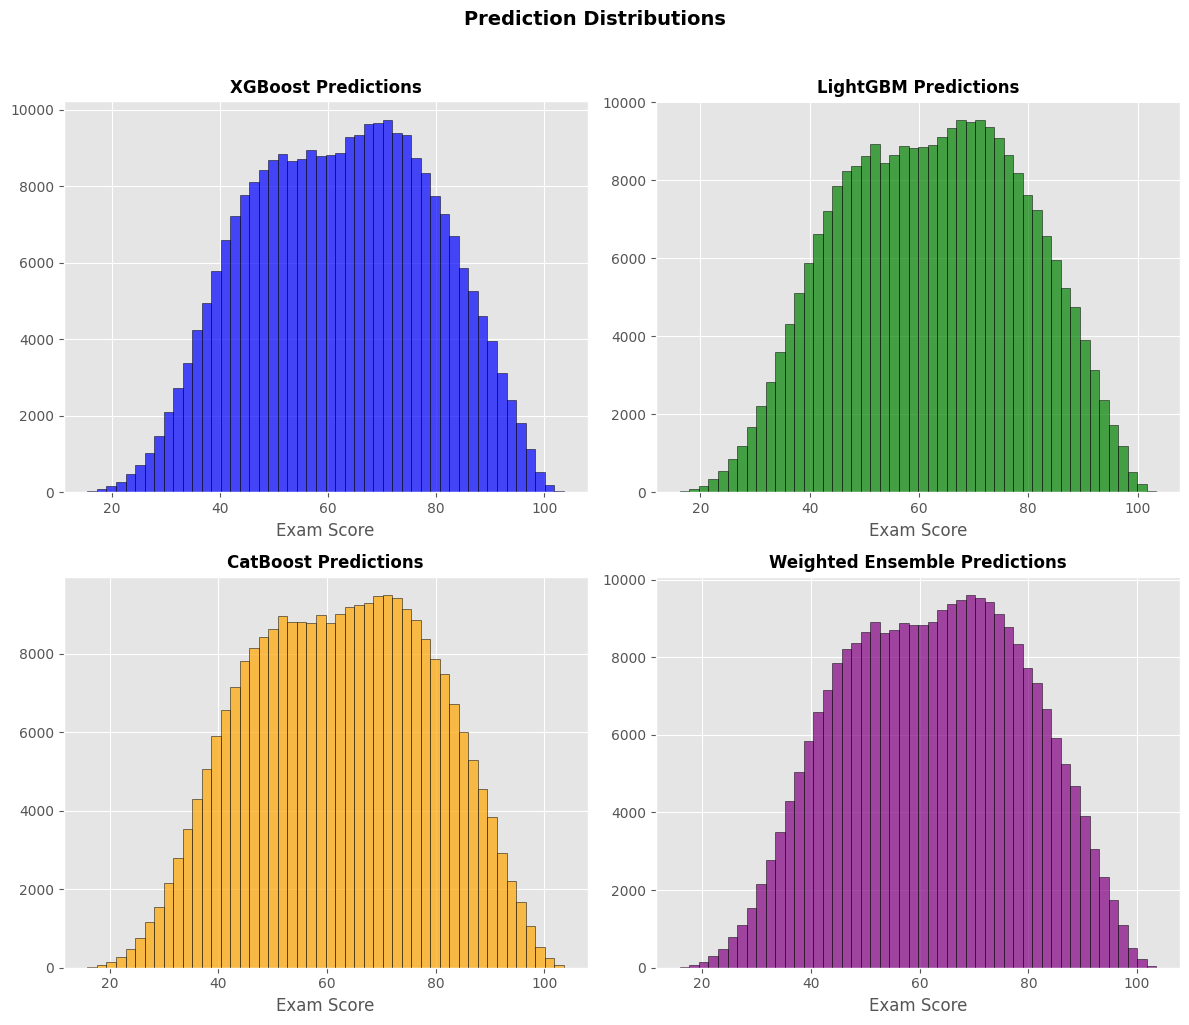

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(pred_xgb, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('XGBoost Predictions', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Exam Score')

axes[0, 1].hist(pred_lgbm, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('LightGBM Predictions', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Exam Score')

axes[1, 0].hist(pred_catboost, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('CatBoost Predictions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Exam Score')

axes[1, 1].hist(ensemble_weighted, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Weighted Ensemble Predictions', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Exam Score')

plt.suptitle('Prediction Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('prediction_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# `STEP 10: CREATE SUBMISSION`

GRANDMASTER TIP #14: Double-check your submission format! <br>
Many people lose points due to formatting errors. 

> ## 10.1 Create Submission DataFrames

In [31]:
# Submission 1: XGBoost only
submission_xgb = pd.DataFrame({
    'id': test_ids,
    'exam_score': pred_xgb
})

# Submission 2: LightGBM only
submission_lgbm = pd.DataFrame({
    'id':  test_ids,
    'exam_score': pred_lgbm
})

# Submission 3: CatBoost only
submission_catboost = pd.DataFrame({
    'id': test_ids,
    'exam_score': pred_catboost
})

# Submission 4: Weighted Ensemble (Recommended!)
submission_ensemble = pd.DataFrame({
    'id':  test_ids,
    'exam_score': ensemble_weighted
})


> ## 10.2 Validate Submission Format

In [32]:
# Check against sample submission
print(f"   Sample submission shape: {sample_submission.shape}")
print(f"   Our submission shape: {submission_ensemble.shape}")
print(f"   Columns match: {list(sample_submission.columns) == list(submission_ensemble.columns)}")
print(f"   ID count match: {len(sample_submission) == len(submission_ensemble)}")

# Preview submission
print("\n Submission preview:")
print(submission_ensemble.head(10))

# Check for any issues
print("\n Submission statistics:")
print(submission_ensemble['exam_score'].describe())

# Check for NaN or infinite values
print(f"\n   NaN values: {submission_ensemble['exam_score'].isna().sum()}")
print(f"   Infinite values: {np.isinf(submission_ensemble['exam_score']).sum()}")

   Sample submission shape: (270000, 2)
   Our submission shape: (270000, 2)
   Columns match: True
   ID count match: True

 Submission preview:
       id  exam_score
0  630000   72.337682
1  630001   70.247690
2  630002   87.680236
3  630003   55.566152
4  630004   47.050845
5  630005   71.984519
6  630006   73.094033
7  630007   58.447505
8  630008   78.483879
9  630009   91.145124

 Submission statistics:
count    270000.000000
mean         62.518755
std          16.709222
min          15.910759
25%          49.443760
50%          62.894979
75%          75.505520
max         103.519530
Name: exam_score, dtype: float64

   NaN values: 0
   Infinite values: 0


> ## 10.3 Save Submissions

In [33]:
# Save all submissions
submission_xgb.to_csv('submission_xgb.csv', index=False)
submission_lgbm.to_csv('submission_lgbm.csv', index=False)
submission_catboost.to_csv('submission_catboost.csv', index=False)
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print(" submission_xgb.csv saved!")
print(" submission_lgbm.csv saved!")
print(" submission_catboost.csv saved!")
print(" submission_ensemble.csv saved!  (RECOMMENDED)")

 submission_xgb.csv saved!
 submission_lgbm.csv saved!
 submission_catboost.csv saved!
 submission_ensemble.csv saved!  (RECOMMENDED)


# `FINAL SUMMARY`

> ### `COMPETITION PIPELINE COMPLETE!`


SUMMARY OF WHAT WE DID:

1. LOADED DATA
   - Explored train.csv, test.csv, sample_submission.csv
   
2. EXPLORATORY DATA ANALYSIS
   - Analyzed target distribution
   - Checked missing values
   - Visualized feature distributions
   - Analyzed correlations
   - Detected outliers
   - Compared train vs test distributions

3. DATA PREPROCESSING
   - Handled missing values
   - Encoded categorical variables
   - Scaled features

4. FEATURE ENGINEERING
   - Created statistical features
   - Created polynomial features
   - Created interaction features
   - Created binned features

5. MODEL BUILDING
   - Trained 11 different models
   - Compared performance using RMSE

6. CROSS-VALIDATION
   - Used 5-fold cross-validation
   - Got reliable performance estimates

7. HYPERPARAMETER TUNING
   - Used Optuna for smart tuning
   - Tuned XGBoost, LightGBM, CatBoost

8. ENSEMBLE METHODS
   - Combined top models
   - Used weighted averaging

9. CREATED SUBMISSIONS
   - Generated 4 submission files
   - Recommended: submission_ensemble.csv


> ### `NEXT STEPS TO IMPROVE:`

1. Add the original dataset
   - Download from: Exam score prediction dataset
   - Combine with synthetic data for more training samples

2. More feature engineering
   - Domain-specific features
   - Target encoding
   - Feature selection

3. Advanced ensembling
   - Stacking with meta-learner
   - Blending
   - Hill climbing for weights

4. More hyperparameter tuning
   - Increase n_trials in Optuna
   - Try different search spaces

5. Post-processing
   - Clip predictions to valid range
   - Round to specific decimal places

6. Experiment tracking
   - Use MLflow or Weights & Biases
   - Track all experiments systematically


### Connect with Me  

Feel free to follow me on these platforms: 

[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/AdilShamim8)  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/adilshamim8)  
[![Twitter](https://img.shields.io/badge/Twitter-1DA1F2?style=for-the-badge&logo=twitter&logoColor=white)](https://x.com/adil_shamim8)  